# Логистическая регрессия и анализ изображений


В этом ноутбуке предлагается построить классификатор изображений на основе логистической регрессии.


Stanford CS 229 notes on linear models:
http://cs229.stanford.edu/notes/cs229-notes1.pdf

ROC-AUC easily (на Русском):
https://dyakonov.org/2017/07/28/auc-roc-площадь-под-кривой-ошибок/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

%matplotlib inline

## 1. Постановка задачи ##


**Задача**: Есть [датасет](https://drive.google.com/file/d/15tOimf2QYWsMtPJXTUCwgZaOTF8Nxcsm/view?usp=sharing) ("catvnoncat.h5") состоящий из:
    - обучающей выборки из m_train изображений, помеченных "cat" (y=1) или "non-cat" (y=0)
    - тестовой выборки m_test изображений, помеченных "cat" или "non-cat"
    - каждое цветное изображение имеет размер (src_size, src_size, 3), где 3 - число каналов (RGB).
    Таким образом, каждый слой - квадрат размера src_size x src_size$.

Давайте построим простой алгоритм классификации изображений на классы "cat"/"non-cat".

<img src="img/LogReg_kiank.png" style="width:650px;height:400px;">

**Recap**:

Для каждого примера $x^{(i)}$:
$$z^{(i)} = w^T x^{(i)} + b \tag{1}$$
$$\hat{y}^{(i)} = a^{(i)} = sigmoid(z^{(i)})\tag{2}$$ 
$$ \mathcal{L}(a^{(i)}, y^{(i)}) =  - y^{(i)}  \log(a^{(i)}) - (1-y^{(i)} )  \log(1-a^{(i)})\tag{3}$$

Функция потерь:
$$ J = \frac{1}{m} \sum_{i=1}^m \mathcal{L}(a^{(i)}, y^{(i)})\tag{6}$$

### 1.1 Загрузка данных и визуализация ###

In [2]:
def load_dataset():
    train_data = h5py.File(r"data/train_catvnoncat.h5", "r")
    train_set_x_orig = np.array(train_data["train_set_x"][:]) # признаки
    train_set_y_orig = np.array(train_data["train_set_y"][:]) # метки классов

    test_data = h5py.File(r"data/test_catvnoncat.h5", "r")
    test_set_x_orig = np.array(test_data["test_set_x"][:]) # признаки
    test_set_y_orig = np.array(test_data["test_set_y"][:]) # метки классов

    classes = np.array(test_data["list_classes"][:]) # the list of classes
    classes = np.array(list(map(lambda x: x.decode('utf-8'), classes)))
    
    train_set_y = train_set_y_orig.reshape(train_set_y_orig.shape[0])
    test_set_y = test_set_y_orig.reshape(test_set_y_orig.shape[0])
    return train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes

In [3]:
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

Цветные изображения в формате RGB представлены в виде трёхмерных numpy.array.

Порядок измерений $H \times W \times C$: $H$ - высота, $W$ - ширина и $C$ - число каналов.

Значение каждого пиксела находится в интервале $[0;255]$.

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def show_image_interact(i=0):
    f, ax = plt.subplots(1,4, figsize=(15,20), sharey=True)
    
    ax[0].imshow(train_set_x_orig[i])
    ax[0].set_title('RGB image')
    ax[1].imshow(train_set_x_orig[i][:,:,0], cmap='gray')
    ax[1].set_title('R channel')
    ax[2].imshow(train_set_x_orig[i][:,:,1], cmap='gray')
    ax[2].set_title('G channel')
    ax[3].imshow(train_set_x_orig[i][:,:,2], cmap='gray')
    ax[3].set_title('B channel')
    
    print("y = {} belongs to '{}' class.".format(str(train_set_y[i]),classes[np.squeeze(train_set_y[i])]))

interact(show_image_interact,
         i=widgets.IntSlider(min=0, max=len(train_set_y)-1, step=1))

interactive(children=(IntSlider(value=0, description='i', max=208), Output()), _dom_classes=('widget-interact'…

<function __main__.show_image_interact(i=0)>

При работе с данными полезно будет сохранить размерности входных изображений для дальнейшей обработки.

In [5]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
src_size = train_set_x_orig.shape[1]

print ("Размер обучающей выборки: m_train = " + str(m_train))
print ("Размер тестовой выборки: m_test = " + str(m_test))
print ("Ширина/Высота каждого изображения: src_size = " + str(src_size))
print ("Размерны трёхмерной матрицы для каждого изображения: (" + str(src_size) + ", " + str(src_size) + ", 3)")
print ("Размерность train_set_x: " + str(train_set_x_orig.shape))
print ("Размерность train_set_y: " + str(train_set_y.shape))
print ("Размерность test_set_x: " + str(test_set_x_orig.shape))
print ("Размерность test_set_y: " + str(test_set_y.shape))

Размер обучающей выборки: m_train = 209
Размер тестовой выборки: m_test = 50
Ширина/Высота каждого изображения: src_size = 64
Размерны трёхмерной матрицы для каждого изображения: (64, 64, 3)
Размерность train_set_x: (209, 64, 64, 3)
Размерность train_set_y: (209,)
Размерность test_set_x: (50, 64, 64, 3)
Размерность test_set_y: (50,)


## 2. Предварительная обработка

Преобразуем входные изображения размера (num_px, num_px, 3) в вектор признаков размера (num_px $*$ num_px $*$ 3, 1), чтобы сформировать матрицы объект-признак в виде numpy-array для обучающей и тестовой выборок.

Каждой строке матрицы объект-признак соответствует входное развёрнутое в вектор-строку изображение.

Помимо этого, для предварительной обработки (препроцессинга) изображений применяют центрирование значений: из значения каждого пиксела вычитается среднее и делят полученное значение на среднеквадратичное отклонение значений пикселей всего изображения.

Однако, на практике обычно просто делят значения пикселей на 255 (максимальное значение пикселя).

Оформим эти шаги в функцию предварительной обработки

In [77]:
def image_preprocessing_simple(data):
    assert type(data) == np.ndarray
    assert data.ndim == 4
    
    n,h,w,c = data.shape
    data_vectorized = data.reshape(data.shape[0], -1)
    data_normalized = data_vectorized / 255
    
    return data_normalized

In [78]:
# Изменить размеры входных данных

train_set_x_vectorized = image_preprocessing_simple(train_set_x_orig)
test_set_x_vectorized = image_preprocessing_simple(test_set_x_orig)

print('Train set:')
print("Размеры train_set_x_vectorized:  {}".format(str(train_set_x_vectorized.shape)))
print("Размеры train_set_y:             {}".format(str(train_set_y.shape)))
print("Размеры классов 'cat'/'non-cat': {} / {}".format(sum(train_set_y==1), sum(train_set_y==0)))
print('Test set:')
print("Размеры test_set_x_vectorized:   {}".format(str(test_set_x_vectorized.shape)))
print("Размеры test_set_y:              {}".format(str(test_set_y.shape)))
print("Размеры классов 'cat'/'non-cat': {} / {}".format(sum(test_set_y==1), sum(test_set_y==0)))

Train set:
Размеры train_set_x_vectorized:  (209, 12288)
Размеры train_set_y:             (209,)
Размеры классов 'cat'/'non-cat': 72 / 137
Test set:
Размеры test_set_x_vectorized:   (50, 12288)
Размеры test_set_y:              (50,)
Размеры классов 'cat'/'non-cat': 33 / 17


## 3. Классификация

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, cross_val_score
import warnings
warnings.filterwarnings('ignore')

**Вопрос**: Какую метрику качества стоит использовать?

### 3.1 Построение модели

Построим  модель с параметрами по умолчанию и посмотрим, как хорошо она справится с задачей.

In [80]:
from sklearn.metrics import accuracy_score
clf = LogisticRegression(C=1000, fit_intercept=True)
clf.fit(train_set_x_vectorized, train_set_y)
predictions = clf.predict(test_set_x_vectorized)
score = accuracy_score(test_set_y, predictions)
print('Точность для простой модели с параметрами по умолчанию: {:.4f}'.format(score))

Точность для простой модели с параметрами по умолчанию: 0.6600


In [81]:
from sklearn.metrics import f1_score
y_predicted = clf.predict(test_set_x_vectorized)
correct_score = f1_score(test_set_y, y_predicted)
print('f1_score для простой модели: {:.4f}'.format(correct_score))

f1_score для простой модели: 0.7018


Попробуем подобрать параметры регуляризации в надежде, что это повысит точность предсказаний.

In [114]:
logReg = LogisticRegression()
logReg.get_params().keys()
param_grid = {
    'C' : [10, 40, 70, 90, 100, 110, 150, 200, 1000, 10000],
    'penalty': ['l1', 'l2']
}
grid_cv = GridSearchCV(logReg, param_grid, cv=5, scoring='accuracy')
grid_cv.fit(train_set_x_vectorized, train_set_y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [10, 40, 70, 90, 100, 110, 150, 200, 1000, 10000], 'penalty': ['l1', 'l2']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [115]:
print('Оптимальные параметры: {}'.format(grid_cv.best_params_  ))
scores = cross_val_score(logReg, train_set_x_vectorized, train_set_y, cv=3)
print ('Среднее значение при CV: {:.4f}'.format(scores.mean()))

Оптимальные параметры: {'C': 10, 'penalty': 'l1'}
Среднее значение при CV: 0.5692


Обучим модель с оптимальными параметрами на всей обучающей выборке и посмотрим на метрики качества:

In [116]:

from sklearn import metrics
c = grid_cv.best_params_['C']
p = grid_cv.best_params_['penalty']
best_clf = LogisticRegression(C=c, penalty=p)
best_clf.fit(train_set_x_vectorized, train_set_y)
y_predicted = best_clf.predict(test_set_x_vectorized)
metric_score = metrics.accuracy_score(y_predicted, test_set_y)

print('Optimal model hyperparameters accuracy score: {:.4f}'.format(metric_score))
#print (metrics.classification_report(test_set_y, y_predicted))
correct_score = metrics.f1_score(test_set_y, y_predicted)
mae = metrics.mean_absolute_error(test_set_y, y_predicted)
r2 = metrics.r2_score(test_set_y, y_predicted)
print('Mean absolute error для простой модели: {:.4f}'.format(mae))
print('Коэффициент детерминации для простой модели: {:.4f}'.format(r2)) #Отриц. значение говорит о крайней неадекватности модели!
print('Precision для простой модели: {:.4f}'.format(metrics.precision_score(test_set_y, y_predicted)))
print('Recall для простой модели: {:.4f}'.format(metrics.recall_score(test_set_y, y_predicted)))
print('f1_score для простой модели: {:.4f}'.format(correct_score))

Optimal model hyperparameters accuracy score: 0.7200
Mean absolute error для простой модели: 0.2800
Коэффициент детерминации для простой модели: -0.2478
Precision для простой модели: 0.8276
Recall для простой модели: 0.7273
f1_score для простой модели: 0.7742


### 3.2 Анализ ошибок

In [130]:
is_outlier = (y_predicted != test_set_y)
test_outliers_x, test_outliers_y, predicted_y = test_set_x_orig[is_outlier], test_set_y[is_outlier], y_predicted[is_outlier]

In [120]:
def show_image_outliers(i=0):
    f = plt.figure(figsize=(5,5))
    plt.imshow(test_outliers_x[i])
    plt.title('RGB image')
    
    fmt_string = "Sample belongs to '{}' class, but '{}' is predicted'"
    print(fmt_string.format(classes[test_outliers_y[i]], classes[predicted_y[i]]))

interact(show_image_outliers,
         i=widgets.IntSlider(min=0, max=len(test_outliers_y)-1, step=1))


interactive(children=(IntSlider(value=0, description='i', max=13), Output()), _dom_classes=('widget-interact',…

<function __main__.show_image_outliers(i=0)>

**Вопрос**: Как по-вашему можно повысить точность? Каким недостатком обладает данный подход к классификации?

### 3.3 Модель с аугментациями

Как можно увеличить количество данных для обучения?

Сформировать новые примеры из уже имеющихся!

Например, можно пополнить class 'cat' обучающей выборки [зеркально отображёнными](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fliplr.html) изображениями котов.

In [121]:
def augment_sample(src, label):
    return 1

def image_preprocessing_augment(data, labels):
    assert type(data) == np.ndarray
    assert data.ndim == 4
    
    ## ВАШ КОД ##
    
    
    data_augmented = np.fliplr(data)
    labels_augmented = labels
    ## ВАШ КОД ЗАКАНЧИВАЕТСЯ ЗДЕСЬ ##
    
    n,h,w,c = data_augmented.shape
    data_vectorized = data_augmented.reshape(data_augmented.shape[0], -1) 
    data_normalized = data_vectorized / 255
    
    return data_normalized, labels_augmented

In [122]:
train_set_x_augmented, train_set_y_augmented = image_preprocessing_augment(train_set_x_orig, train_set_y)

In [123]:
clf = LogisticRegression(solver='liblinear')
clf.fit(train_set_x_augmented, train_set_y_augmented)
y_pred = clf.predict(test_set_x_vectorized)
print('F-мера для модели с аугментациями: {:.4f}'.format(f1_score(y_pred, test_set_y)))

F-мера для модели с аугментациями: 0.5600


## 4. Проверьте работу классификатора на своей картинке

Библиотека [OpenCV](https://opencv.org) для работы с изображениями для [python](https://pypi.org/project/opencv-python/):

`pip install opencv-python`

Вместе с contrib-модулями:

`pip install opencv-contrib-python`


Алгоритм говорит, что это '1': cat


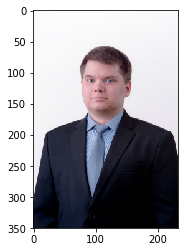

In [129]:
###### import cv2

# Путь к картинке на вашем ПК
fname = "5.jpg"
# Считываем картинку через scipy
src = cv2.cvtColor(cv2.imread((fname)), cv2.COLOR_BGR2RGB)
src_resized = cv2.resize(src, (src_size,src_size), interpolation=cv2.INTER_LINEAR).reshape(1, src_size*src_size*3)
my_image_predict = clf.predict(src_resized)[0]

plt.imshow(src)
print("Алгоритм говорит, что это '{}': {}".format(my_image_predict, classes[my_image_predict]))